In [1]:
import sqlite3
import pandas as pd
import os
import re
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.metrics import accuracy_score, roc_curve, auc,  precision_recall_curve, average_precision_score
from sklearn.grid_search import GridSearchCV
from nltk.tokenize import sent_tokenize, word_tokenize, StanfordTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import string
import seaborn as sns
sns.set_style("whitegrid")
os.chdir('/Users/RayLJazz//Dropbox/UCDavis/2016spring/STA208/Github/Data')

# Read Pickles

In [2]:
SOM = pd.read_pickle('stackoverflow_metric_df.pickle')
RM = pd.read_pickle('Readability_Metrics_wtbody.pickle')
PM = pd.read_pickle('popularity_metric.pickle')
tag_rank=pd.read_pickle('tag_rank.pickle')

In [3]:
query = "SELECT * FROM [posts]"
conn = sqlite3.connect('crossvalidated.db')
post_df = pd.read_sql_query(query, conn)
post_df.head()
qpost_df = post_df[post_df.PostTypeId == 1]

## Stackoverflow Metrics

In [65]:
SOM.head()

,Id,ClosedDate,Score,BodyLen,LowerCasePer,UpperCasePer,SpaceCnt,TagCnt,Sentimental_Polarity,Sentimental_Subjectivity,TitleLen,UrlCnt
0,1,None,31,91,0.958763,0.041237,15,3,0.133333,0.133333,29,0
1,2,None,26,146,0.969466,0.030534,25,2,0.000000,0.000000,18,0
2,3,None,63,206,0.963303,0.036697,36,2,0.021875,0.596875,65,0
3,4,None,15,497,0.970982,0.029018,90,2,0.129808,0.552885,58,0
5,6,None,226,1628,0.962547,0.037453,204,1,-0.150000,0.300000,50,4


In [66]:
SOM.shape

(75067, 12)

In [67]:
predictors_SOM = [x for x in SOM.columns if x not in ['ClosedDate','Score']]

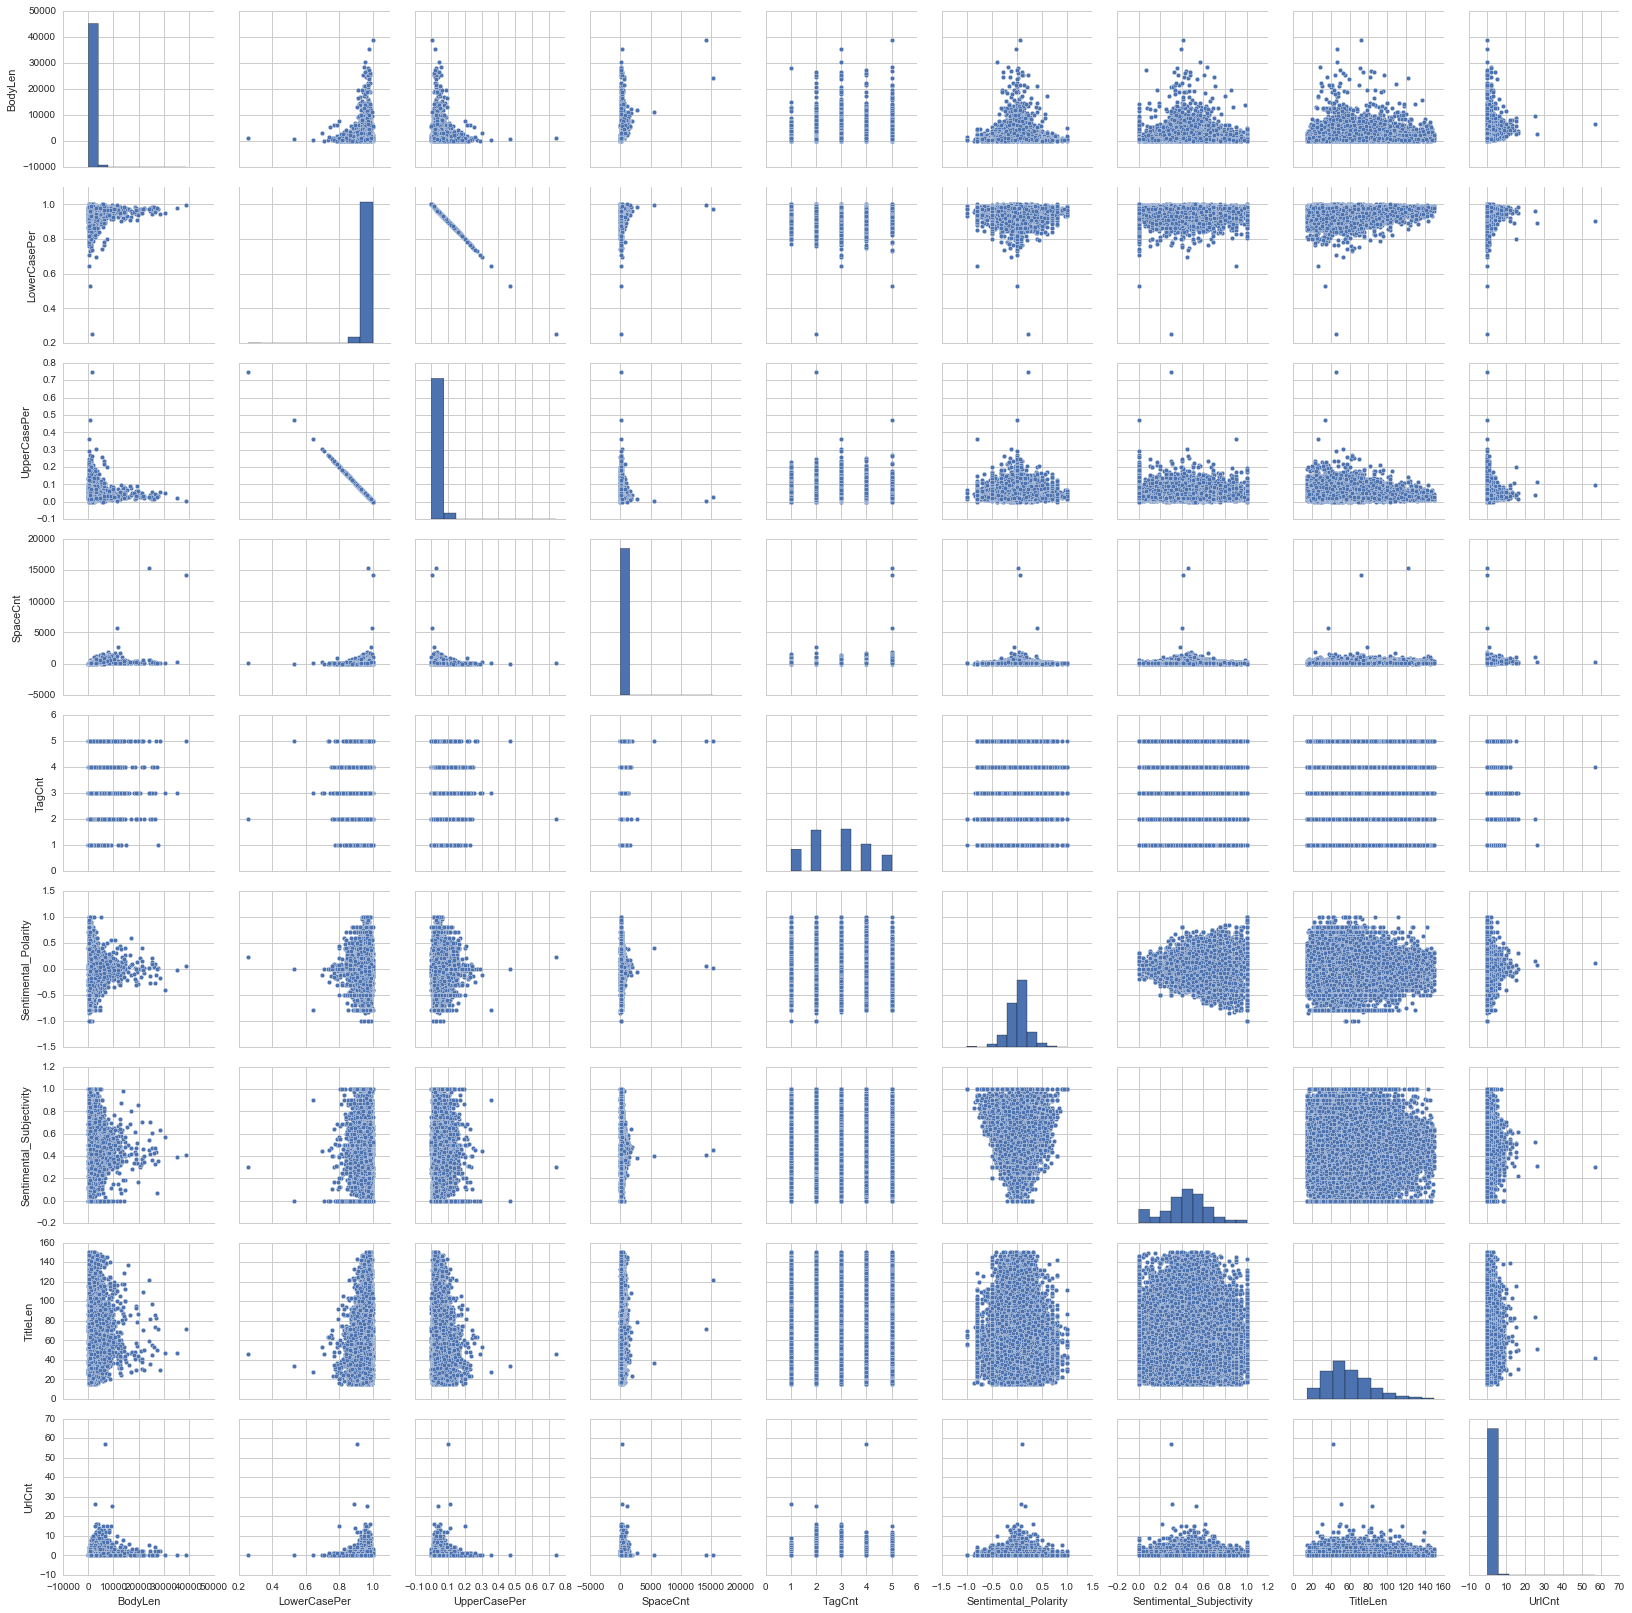

In [68]:
sns.pairplot(SOM[predictors_SOM].drop('Id',1).replace('NA', np.nan).dropna(axis=0, how='any'))

## Readability Metrics

In [70]:
RM['tag_rank']=tag_rank

In [71]:
RM.head()

,Id,Code number,formula,Imagine,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per,Score,tag_rank
0,1,0,0,0,13,1,10.41,13.15,9.45,50.47,23.66,0.006138,0.0,31,3
1,2,0,0,0,23,2,6.65,9.11,10.96,37.00,15.03,0.003698,0.0,26,2
2,3,0,0,0,29,1,18.55,14.58,18.51,14.03,19.88,0.002751,0.0,63,4
3,4,0,0,0,81,5,9.04,9.94,10.98,45.21,9.44,0.001103,0.0,15,1
5,6,0,0,0,185,7,17.17,14.34,16.47,24.07,11.87,0.000373,0.0,226,2


In [73]:
RM.shape

(75067, 15)

In [130]:
predictors_RM = [x for x in RM.columns if x not in ['Score','Code number']]

In [131]:
RM[predictors_RM].head()

,Id,formula,Imagine,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per,tag_rank
0,1,0,0,13,1,10.41,13.15,9.45,50.47,23.66,0.006138,0.0,3
1,2,0,0,23,2,6.65,9.11,10.96,37.00,15.03,0.003698,0.0,2
2,3,0,0,29,1,18.55,14.58,18.51,14.03,19.88,0.002751,0.0,4
3,4,0,0,81,5,9.04,9.94,10.98,45.21,9.44,0.001103,0.0,1
5,6,0,0,185,7,17.17,14.34,16.47,24.07,11.87,0.000373,0.0,2


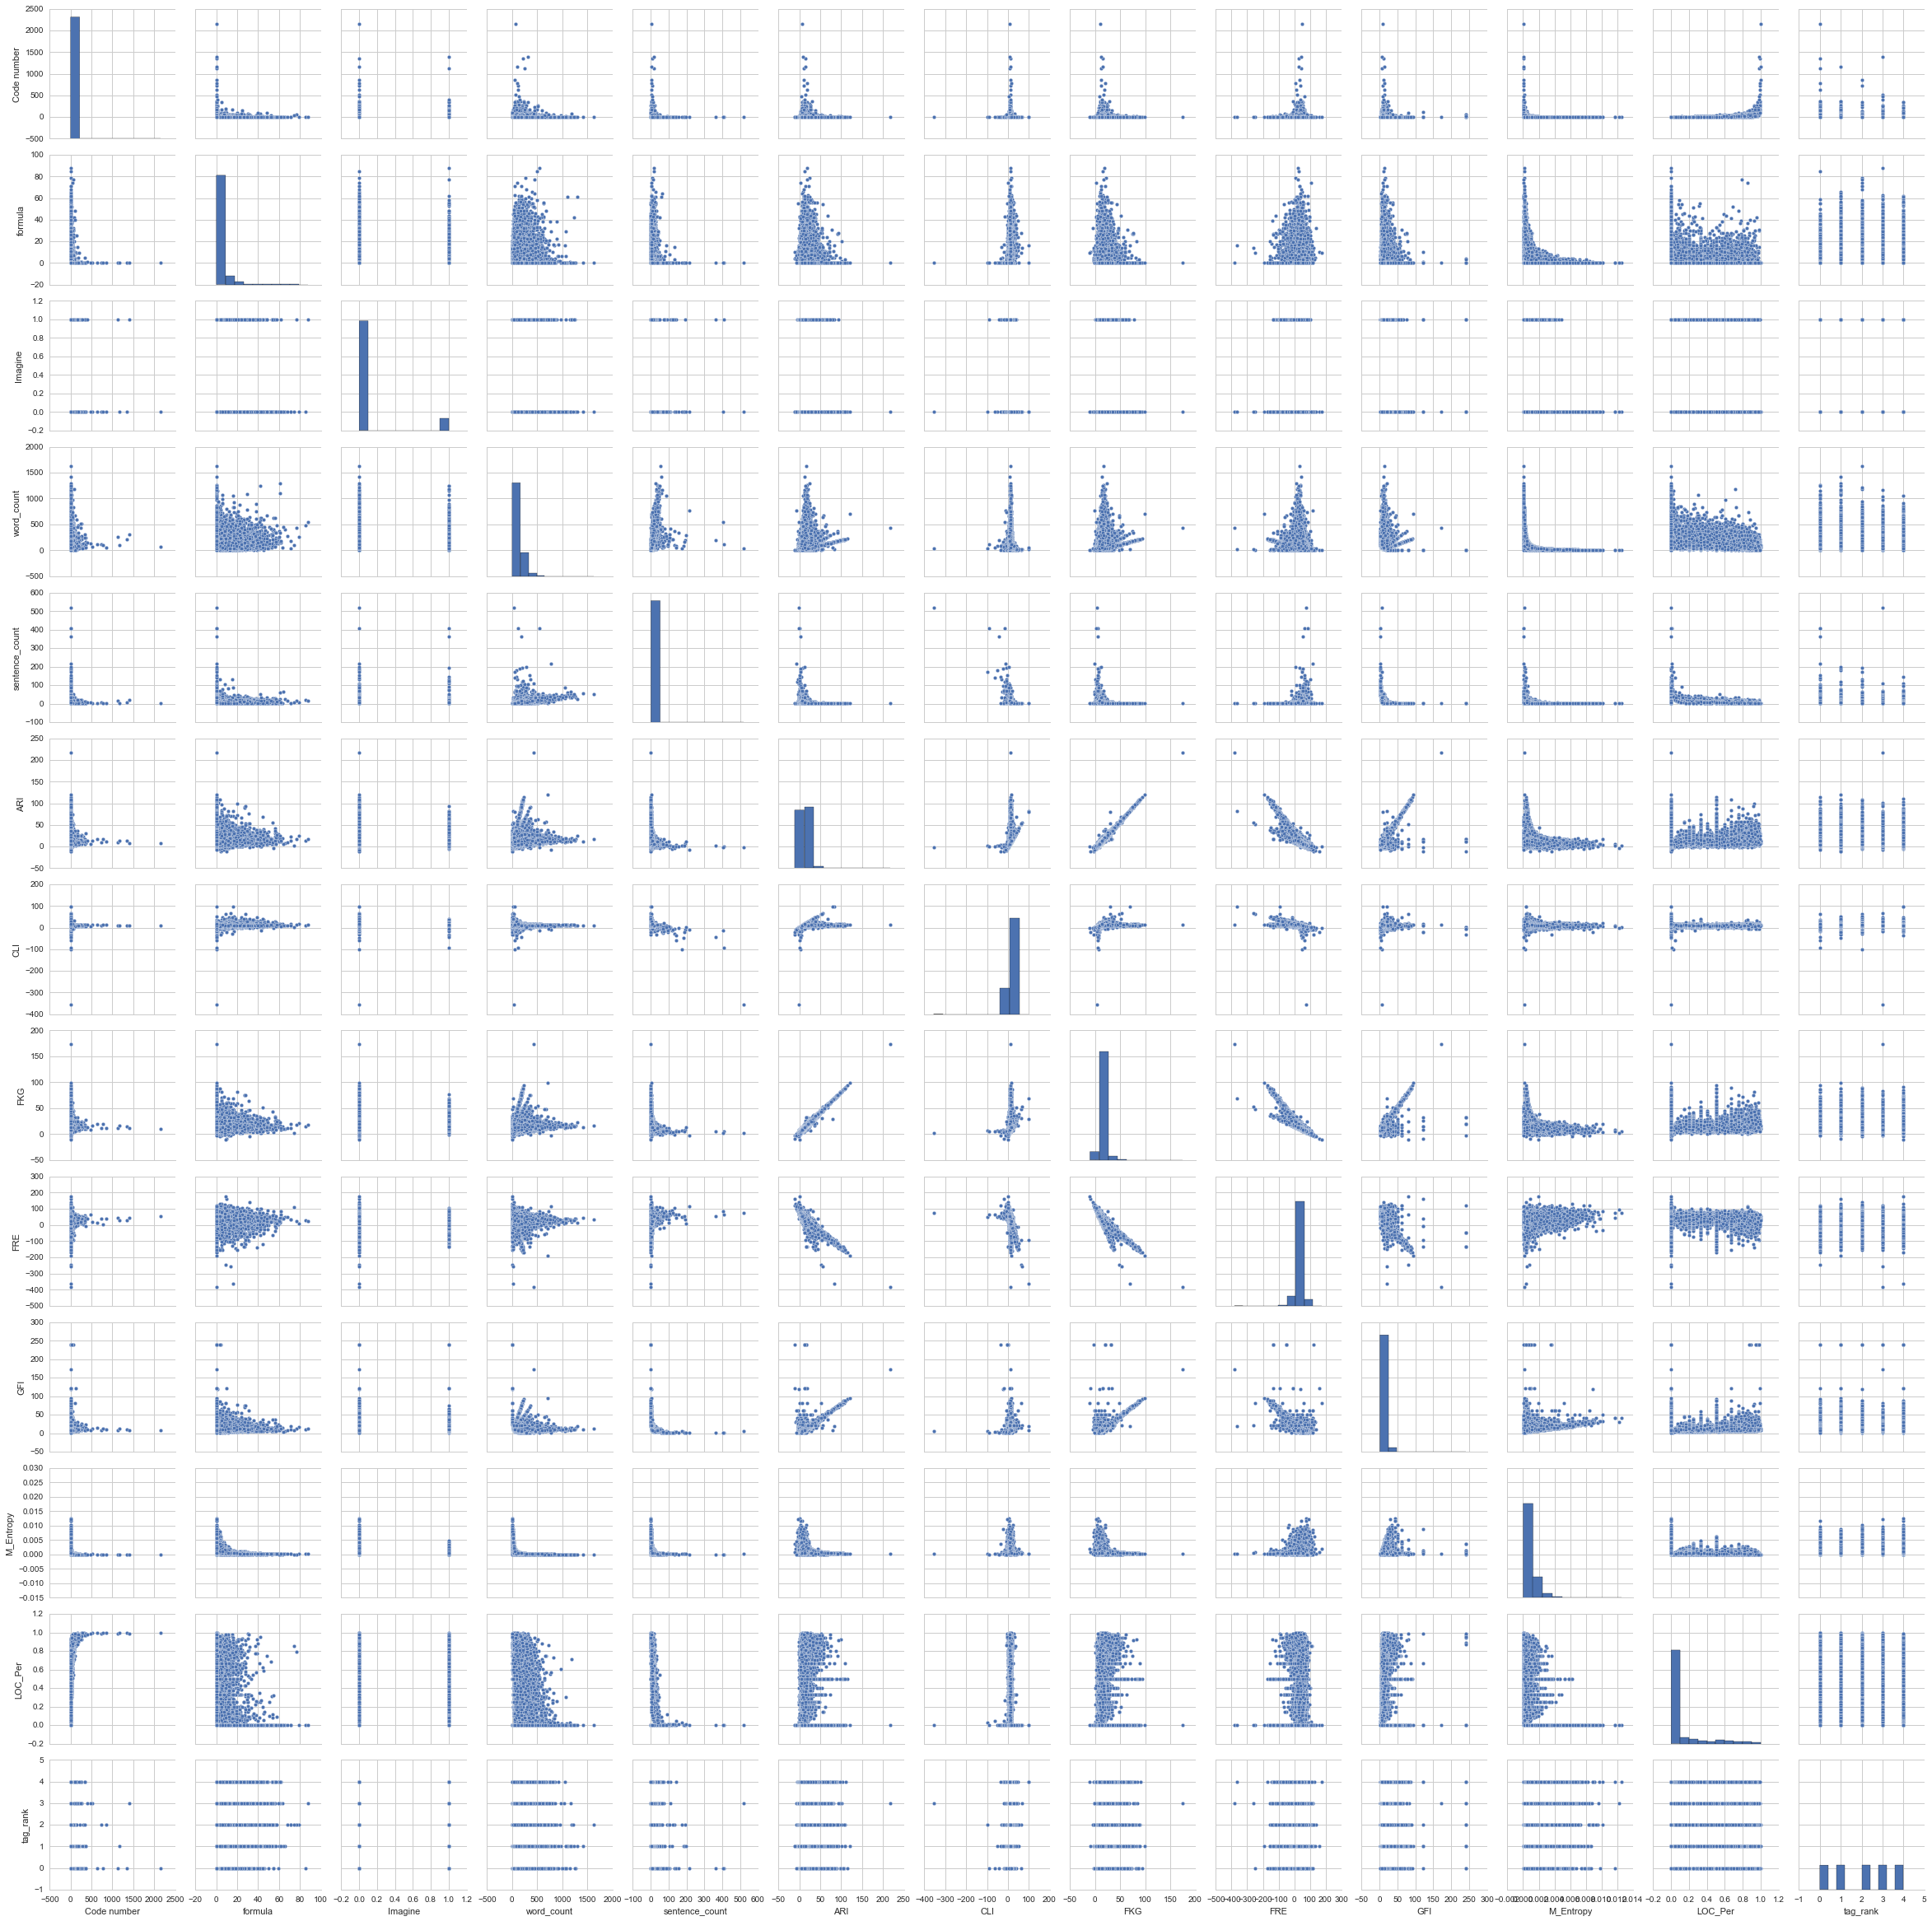

In [76]:
sns.pairplot(RM[predictors_RM].drop('Id',1).replace('NaN', np.nan).dropna(axis=0, how='any'))

## Popularity Metrics

In [77]:
PM.head()

,Id,CreationDate,OwnerUserId,AccpAnsCnt,AppEditCnt,BadgeCnt,CloDelVCnt,UpVoteCnt,DownVoteCnt,FavVoteCnt,Score
0,1,2010-07-19 19:12:12.510,8.0,0,0,0,0,0,0,0,31
1,2,2010-07-19 19:12:57.157,24.0,0,0,0,0,0,0,0,26
2,3,2010-07-19 19:13:28.577,18.0,0,0,0,0,0,0,0,63
3,4,2010-07-19 19:13:31.617,23.0,0,0,0,0,0,0,0,15
4,6,2010-07-19 19:14:44.080,5.0,0,0,0,0,0,0,0,226


In [78]:
PM.shape

(75067, 11)

In [79]:
predictors_PM = [x for x in PM.columns if x not in ['CreationDate','OwnerUserId','Score']]
target = 'Score'

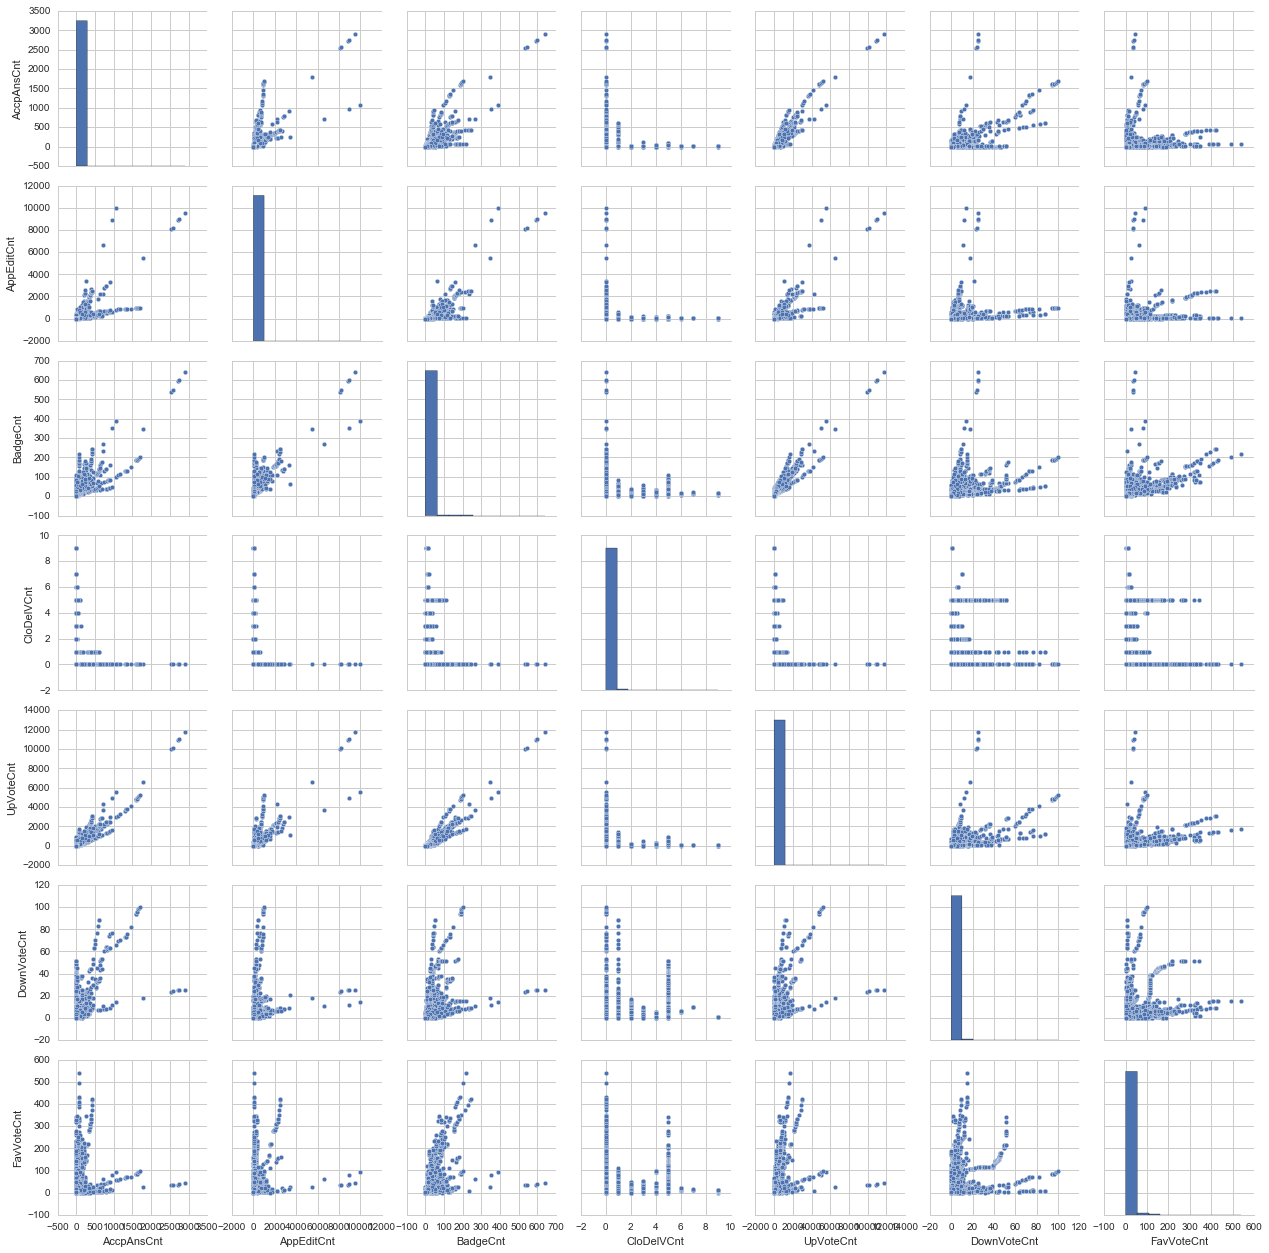

In [80]:
sns.pairplot(PM[predictors_PM].drop('Id',1))

In [132]:
dfs = [SOM[predictors_SOM],RM[predictors_RM],PM[predictors_PM],PM[['Id','Score']]]
data_SOQ = reduce(lambda left,right: pd.merge(left,right,on='Id'), dfs)

In [133]:
data_SOQ.shape, data_SOQ.columns

((75067, 30), Index([                      u'Id',                  u'BodyLen',
                    u'LowerCasePer',             u'UpperCasePer',
                        u'SpaceCnt',                   u'TagCnt',
            u'Sentimental_Polarity', u'Sentimental_Subjectivity',
                        u'TitleLen',                   u'UrlCnt',
                         u'formula',                  u'Imagine',
                      u'word_count',           u'sentence_count',
                             u'ARI',                      u'CLI',
                             u'FKG',                      u'FRE',
                             u'GFI',                u'M_Entropy',
                         u'LOC_Per',                 u'tag_rank',
                      u'AccpAnsCnt',               u'AppEditCnt',
                        u'BadgeCnt',               u'CloDelVCnt',
                       u'UpVoteCnt',              u'DownVoteCnt',
                      u'FavVoteCnt',                    u'Score

In [134]:
Class = []
def identify_class(row):
    if (row['Score']>0) & (row['ClosedDate'] is None):
        Class.append(1)
    elif (row['Score']<=0) & (row['ClosedDate']is None):
        Class.append(0)
    elif (row['ClosedDate']is not None):
        Class.append(0)

In [135]:
data_SOQ_class = qpost_df.apply(identify_class,axis=1)

In [136]:
Class_df = pd.Series(data=Class)
data_SOQ['Class'] = Class_df
data_SOQ['Class'].value_counts()

1    49269
0    25798
Name: Class, dtype: int64

In [137]:
Class_char = pd.Categorical.from_codes(data_SOQ['Class'], ['B','G'])
data_SOQ['Class_char'] = Class_char
data_SOQ=data_SOQ.replace('NA', np.nan)
data_SOQ=data_SOQ.replace('NaN', np.nan)
data_SOQ_rna = data_SOQ.dropna(axis=0, how='any')

In [138]:
data_SOQ.head(n=10)
target = 'Class'
Predictors = [x for x in data_SOQ.columns if x not in ['Id','Score','Class_char','Class','Code number']]
Predictors

[u'BodyLen',
 u'LowerCasePer',
 u'UpperCasePer',
 u'SpaceCnt',
 u'TagCnt',
 u'Sentimental_Polarity',
 u'Sentimental_Subjectivity',
 u'TitleLen',
 u'UrlCnt',
 u'formula',
 u'Imagine',
 u'word_count',
 u'sentence_count',
 u'ARI',
 u'CLI',
 u'FKG',
 u'FRE',
 u'GFI',
 u'M_Entropy',
 u'LOC_Per',
 'tag_rank',
 'AccpAnsCnt',
 'AppEditCnt',
 'BadgeCnt',
 'CloDelVCnt',
 'UpVoteCnt',
 'DownVoteCnt',
 'FavVoteCnt']

In [4]:
import pickle
with open('data_SOQ_rna_binary2.pickle', 'wb') as handle:
    pickle.dump(data_SOQ_rna, handle,protocol=2)
data_SOQ_rna=pd.read_pickle('data_SOQ_rna_binary1.pickle')

In [5]:
Predictors =[u'BodyLen',
 u'LowerCasePer',
 u'UpperCasePer',
 u'SpaceCnt',
 u'TagCnt',
 u'Sentimental_Polarity',
 u'Sentimental_Subjectivity',
 u'TitleLen',
 u'UrlCnt',
 u'formula',
 u'Imagine',
 u'word_count',
 u'sentence_count',
 u'ARI',
 u'CLI',
 u'FKG',
 u'FRE',
 u'GFI',
 u'M_Entropy',
 u'LOC_Per',
 'tag_rank',
 'AccpAnsCnt',
 'AppEditCnt',
 'BadgeCnt',
 'CloDelVCnt',
 'UpVoteCnt',
 'DownVoteCnt',
 'FavVoteCnt']

In [6]:
data_SOQ_rna.shape, data_SOQ_rna.dtypes

((75067, 33), Id                             int64
 BodyLen                        int64
 LowerCasePer                 float64
 UpperCasePer                 float64
 SpaceCnt                       int64
 TagCnt                         int64
 Sentimental_Polarity         float64
 Sentimental_Subjectivity     float64
 TitleLen                       int64
 UrlCnt                         int64
 Code number                    int64
 formula                        int64
 Imagine                        int64
 word_count                     int64
 sentence_count                 int64
 ARI                          float64
 CLI                          float64
 FKG                          float64
 FRE                          float64
 GFI                          float64
 M_Entropy                    float64
 LOC_Per                      float64
 tag_rank                       int64
 AccpAnsCnt                     int64
 AppEditCnt                     int64
 BadgeCnt                       int64

# Modeling-- Random Forest

In [7]:
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_SOQ_rna[Predictors], data_SOQ_rna['Class'], test_size=0.3,random_state=1,stratify=data_SOQ_rna['Class'])

In [8]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((52546, 28), (22521, 28), (52546,), (22521,))

In [9]:
train_y.value_counts(),  test_y.value_counts()

(1    34488
 0    18058
 Name: Class, dtype: int64, 1    14781
 0     7740
 Name: Class, dtype: int64)

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=1,oob_score = True)

In [11]:
param_grid = { 
    'n_estimators': range(200,1100,100)
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_clf.fit(train_x[Predictors], train_y)
CV_clf.grid_scores_, CV_clf.best_params_, CV_clf.best_score_

([mean: 0.65779, std: 0.00246, params: {'n_estimators': 200},
  mean: 0.65923, std: 0.00313, params: {'n_estimators': 300},
  mean: 0.66034, std: 0.00241, params: {'n_estimators': 400},
  mean: 0.66085, std: 0.00216, params: {'n_estimators': 500},
  mean: 0.66083, std: 0.00247, params: {'n_estimators': 600},
  mean: 0.66108, std: 0.00282, params: {'n_estimators': 700},
  mean: 0.66136, std: 0.00248, params: {'n_estimators': 800},
  mean: 0.66165, std: 0.00242, params: {'n_estimators': 900},
  mean: 0.66178, std: 0.00247, params: {'n_estimators': 1000}],
 {'n_estimators': 1000},
 0.66178205762569942)

In [12]:
clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=1,oob_score = True)

In [13]:
clf.fit(train_x[Predictors], train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [14]:
clf.oob_score_, clf.feature_importances_

(0.66162981007117572,
 array([ 0.05653359,  0.05633925,  0.05635826,  0.05015072,  0.02184953,
         0.05514415,  0.05499776,  0.05634993,  0.00943069,  0.02034578,
         0.00493571,  0.04986192,  0.02135983,  0.0543361 ,  0.05972295,
         0.05410522,  0.05692025,  0.05164018,  0.05642487,  0.01826098,
         0.02207162,  0.01444998,  0.01861479,  0.02538805,  0.00170451,
         0.0314121 ,  0.00685108,  0.0144402 ]))

In [15]:
preds = clf.predict(test_x[Predictors])
print metrics.accuracy_score(test_y, preds),
print('ROC: %f' % (metrics.roc_auc_score(test_y, preds)))

0.660450246437 ROC: 0.538411


In [16]:
pd.crosstab(test_y, preds, rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,1146,6594
1,1053,13728


In [ ]:
def plot_featureimportance(model_feature):
    feature_importance = pd.DataFrame(model_feature, index = Predictors)
    feature_importance = feature_importance.sort(0,ascending=False)
    #plt.figure(figsize=(10, 8))
    feature_importance.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')
    plt.show()

In [ ]:
plot_featureimportance(clf.feature_importances_)

## Extreme Gradient Boosting

### Step 1- Find the number of estimators for a high learning rate

In [44]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [48]:
train = train_x
train['Class'] = train_y
test = test_x
test['Class'] = test_y

In [50]:
train.shape, test.shape,train.columns

((52546, 30),
 (22521, 30),
 Index([                 u'BodyLen',             u'LowerCasePer',
                    u'UpperCasePer',                 u'SpaceCnt',
                          u'TagCnt',     u'Sentimental_Polarity',
        u'Sentimental_Subjectivity',                 u'TitleLen',
                          u'UrlCnt',                  u'formula',
                         u'Imagine',               u'word_count',
                  u'sentence_count',                      u'ARI',
                             u'CLI',                      u'FKG',
                             u'FRE',                      u'GFI',
                       u'M_Entropy',                  u'LOC_Per',
                        u'tag_rank',               u'AccpAnsCnt',
                      u'AppEditCnt',                 u'BadgeCnt',
                      u'CloDelVCnt',                u'UpVoteCnt',
                     u'DownVoteCnt',               u'FavVoteCnt',
                           u'Score',            

In [34]:
def modelfit(alg, dtrain, dtest, predictors,target, useTrainCV=True, cv_folds=5, early_stopping_round=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values,missing=np.nan)
        xgtest = xgb.DMatrix(dtest[predictors].values,missing=np.nan)
        xgb_param_forcv = xgb_param
        #xgb_param_forcv['num_class'] = 5
        cvresult = xgb.cv(xgb_param_forcv, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_round, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='error')
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    return alg, dtrain_predictions, dtrain_predprob
   

In [149]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb1, dtrain_predictions, dtrain_predprob = modelfit(xgb1, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-error:0.342316+0.00368666987944	cv-train-error:0.3390712+0.00190588996534
[1]	cv-test-error:0.3400704+0.00493486285929	cv-train-error:0.3367256+0.0017403177411
[2]	cv-test-error:0.3395758+0.00501365979699	cv-train-error:0.3360834+0.00137501426902
[3]	cv-test-error:0.338586+0.00480410628525	cv-train-error:0.3358786+0.0010285559975
[4]	cv-test-error:0.3376344+0.00459895086297	cv-train-error:0.335955+0.000932203625824
[5]	cv-test-error:0.3372728+0.00465870219696	cv-train-error:0.3359834+0.00118751498517
[6]	cv-test-error:0.337996+0.00518450599382	cv-train-error:0.3357028+0.00113376389076
[7]	cv-test-error:0.3378818+0.00525799845569	cv-train-error:0.3353982+0.0010326946112
[8]	cv-test-error:0.3374438+0.0054058441487	cv-train-error:0.3351176+0.00110294108637
[9]	cv-test-error:0.3377868+0.00541353098818	cv-train-error:0.335027+0.0010297393845
[10]	cv-test-error:0.3372538+0.00566342777477	cv-train-error:0.3348322+0.001228870

In [35]:
def get_performance(xgbmodel,dtrain,dtest,predictors,dtrain_predictions):
    print "\nModel Report"
    print "Train accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    test_result = xgbmodel.predict(dtest[predictors])
    dtest_predprob = xgbmodel.predict_proba(dtest[predictors])[:,1]
    print "Test accuracy : %.4g" % metrics.accuracy_score(dtest[target].values, test_result)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
    print "AUC Score (Test): %f" % metrics.roc_auc_score(dtest[target], dtest_predprob)
    print pd.crosstab(dtest[target].values, test_result, rownames=['actual'], colnames=['preds'])
    feat_imp = pd.Series(xgbmodel.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')


Model Report
Train accuracy : 0.6791
Test accuracy : 0.6648
AUC Score (Train): 0.687273
AUC Score (Test): 0.644174
preds     0      1
actual            
0       873   6867
1       681  14100


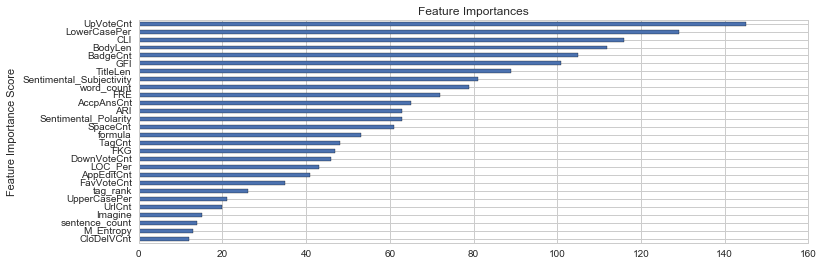

In [151]:
get_performance(xgb1,train,test,Predictors,dtrain_predictions)

### Hyperparameter Tuning
### Step 2: Tune max_depth and min_child_weight

In [152]:
param_test1 = {
 'max_depth':range(2,8,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=63, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[Predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.66167, std: 0.00171, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.66171, std: 0.00170, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.66176, std: 0.00179, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.66174, std: 0.00211, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.66188, std: 0.00199, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.66435, std: 0.00181, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.66447, std: 0.00200, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.66426, std: 0.00230, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.66393, std: 0.00191, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.66380, std: 0.00190, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.66519, std: 0.00193, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.66515, std: 0.00137, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.66542, std: 0.00236, params: {

In [153]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb2, dtrain_predictions, dtrain_predprob = modelfit(xgb2, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-error:0.342316+0.00368666987944	cv-train-error:0.3390712+0.00190588996534
[1]	cv-test-error:0.3400704+0.00493486285929	cv-train-error:0.3367256+0.0017403177411
[2]	cv-test-error:0.3395758+0.00501365979699	cv-train-error:0.3360834+0.00137501426902
[3]	cv-test-error:0.338586+0.00480410628525	cv-train-error:0.3358786+0.0010285559975
[4]	cv-test-error:0.3376344+0.00459895086297	cv-train-error:0.335955+0.000932203625824
[5]	cv-test-error:0.3372728+0.00465870219696	cv-train-error:0.3359834+0.00118751498517
[6]	cv-test-error:0.337996+0.00518450599382	cv-train-error:0.3357028+0.00113376389076
[7]	cv-test-error:0.3378818+0.00525799845569	cv-train-error:0.3353982+0.0010326946112
[8]	cv-test-error:0.3374438+0.0054058441487	cv-train-error:0.3351176+0.00110294108637
[9]	cv-test-error:0.3377868+0.00541353098818	cv-train-error:0.335027+0.0010297393845
[10]	cv-test-error:0.3372538+0.00566342777477	cv-train-error:0.3348322+0.001228870


Model Report
Train accuracy : 0.6791
Test accuracy : 0.6648
AUC Score (Train): 0.687273
AUC Score (Test): 0.644174
preds     0      1
actual            
0       873   6867
1       681  14100


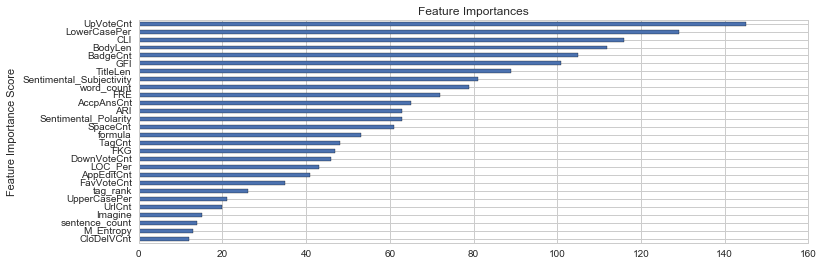

In [154]:
get_performance(xgb2,train,test,Predictors,dtrain_predictions)

## Step 3: Tune gamma

In [155]:
xgb2

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=63, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [156]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,6)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=63, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[Predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.66618, std: 0.00198, params: {'gamma': 0.0},
  mean: 0.66557, std: 0.00204, params: {'gamma': 0.1},
  mean: 0.66538, std: 0.00234, params: {'gamma': 0.2},
  mean: 0.66546, std: 0.00180, params: {'gamma': 0.3},
  mean: 0.66563, std: 0.00216, params: {'gamma': 0.4},
  mean: 0.66515, std: 0.00207, params: {'gamma': 0.5}],
 {'gamma': 0.0},
 0.66617823690671807)

In [157]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb3, dtrain_predictions,dtrain_predprob = modelfit(xgb3, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-error:0.342316+0.00368666987944	cv-train-error:0.3390712+0.00190588996534
[1]	cv-test-error:0.3400704+0.00493486285929	cv-train-error:0.3367256+0.0017403177411
[2]	cv-test-error:0.3395758+0.00501365979699	cv-train-error:0.3360834+0.00137501426902
[3]	cv-test-error:0.338586+0.00480410628525	cv-train-error:0.3358786+0.0010285559975
[4]	cv-test-error:0.3376344+0.00459895086297	cv-train-error:0.335955+0.000932203625824
[5]	cv-test-error:0.3372728+0.00465870219696	cv-train-error:0.3359834+0.00118751498517
[6]	cv-test-error:0.337996+0.00518450599382	cv-train-error:0.3357028+0.00113376389076
[7]	cv-test-error:0.3378818+0.00525799845569	cv-train-error:0.3353982+0.0010326946112
[8]	cv-test-error:0.3374438+0.0054058441487	cv-train-error:0.3351176+0.00110294108637
[9]	cv-test-error:0.3377868+0.00541353098818	cv-train-error:0.335027+0.0010297393845
[10]	cv-test-error:0.3372538+0.00566342777477	cv-train-error:0.3348322+0.001228870


Model Report
Train accuracy : 0.6791
Test accuracy : 0.6648
AUC Score (Train): 0.687273
AUC Score (Test): 0.644174
preds     0      1
actual            
0       873   6867
1       681  14100


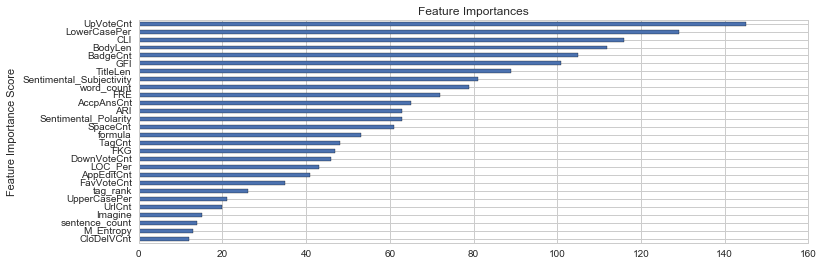

In [158]:
get_performance(xgb3,train,test,Predictors,dtrain_predictions)

## Step 4: Tune subsample and colsample_bytree

In [159]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=63, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[Predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.66498, std: 0.00227, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.66542, std: 0.00287, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.66506, std: 0.00199, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.66502, std: 0.00244, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.66435, std: 0.00253, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.66490, std: 0.00231, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.66648, std: 0.00226, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.66528, std: 0.00202, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.66549, std: 0.00205, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.66555, std: 0.00387, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.66618, std: 0.00198, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.66555, std: 0.00152, params: {'subsample': 0.9, 'colsample_bytree'

In [160]:
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.7,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb4, dtrain_predictions,dtrain_predprob = modelfit(xgb4, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-error:0.3426016+0.00449745121597	cv-train-error:0.3394564+0.00157510489809
[1]	cv-test-error:0.3399752+0.00551176321698	cv-train-error:0.3374156+0.000981826583466
[2]	cv-test-error:0.339804+0.00549688519072	cv-train-error:0.3367494+0.000644322465851
[3]	cv-test-error:0.3394996+0.00510486209804	cv-train-error:0.3363402+0.00104525526069
[4]	cv-test-error:0.338681+0.00518225174996	cv-train-error:0.3359928+0.0012390689085
[5]	cv-test-error:0.3389476+0.00562259550741	cv-train-error:0.3359692+0.000878794947641
[6]	cv-test-error:0.3380338+0.00565683237864	cv-train-error:0.3357362+0.00155815357395
[7]	cv-test-error:0.337406+0.00533210386245	cv-train-error:0.3354028+0.00147452492688
[8]	cv-test-error:0.3376724+0.00528448047021	cv-train-error:0.3353886+0.00132051180987
[9]	cv-test-error:0.337406+0.00548406371225	cv-train-error:0.3350414+0.00112650993782
[10]	cv-test-error:0.3373488+0.00563520673623	cv-train-error:0.3348416+0.00


Model Report
Train accuracy : 0.6911
Test accuracy : 0.6662
AUC Score (Train): 0.715966
AUC Score (Test): 0.645976
preds      0      1
actual             
0       1091   6649
1        868  13913


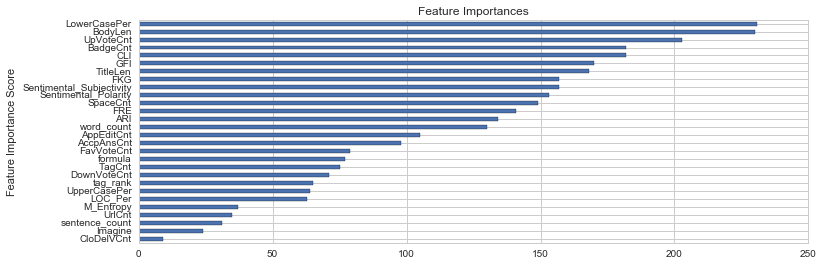

In [161]:
get_performance(xgb4,train,test,Predictors,dtrain_predictions)

## Step 5: Tuning Regularization Parameters

In [162]:
param_test4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=119, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test4, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[Predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.66652, std: 0.00296, params: {'reg_alpha': 0},
  mean: 0.66595, std: 0.00225, params: {'reg_alpha': 0.001},
  mean: 0.66582, std: 0.00241, params: {'reg_alpha': 0.005},
  mean: 0.66597, std: 0.00274, params: {'reg_alpha': 0.01},
  mean: 0.66565, std: 0.00252, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0},
 0.66652075334202343)

In [163]:
xgb5 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.7,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha=0,
        seed=27)
xgb5, dtrain_predictions,dtrain_predprob = modelfit(xgb5, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-error:0.3426016+0.00449745121597	cv-train-error:0.3394564+0.00157510489809
[1]	cv-test-error:0.3399752+0.00551176321698	cv-train-error:0.3374156+0.000981826583466
[2]	cv-test-error:0.339804+0.00549688519072	cv-train-error:0.3367494+0.000644322465851
[3]	cv-test-error:0.3394996+0.00510486209804	cv-train-error:0.3363402+0.00104525526069
[4]	cv-test-error:0.338681+0.00518225174996	cv-train-error:0.3359928+0.0012390689085
[5]	cv-test-error:0.3389476+0.00562259550741	cv-train-error:0.3359692+0.000878794947641
[6]	cv-test-error:0.3380338+0.00565683237864	cv-train-error:0.3357362+0.00155815357395
[7]	cv-test-error:0.337406+0.00533210386245	cv-train-error:0.3354028+0.00147452492688
[8]	cv-test-error:0.3376724+0.00528448047021	cv-train-error:0.3353886+0.00132051180987
[9]	cv-test-error:0.337406+0.00548406371225	cv-train-error:0.3350414+0.00112650993782
[10]	cv-test-error:0.3373488+0.00563520673623	cv-train-error:0.3348416+0.00


Model Report
Train accuracy : 0.6911
Test accuracy : 0.6662
AUC Score (Train): 0.715966
AUC Score (Test): 0.645976
preds      0      1
actual             
0       1091   6649
1        868  13913


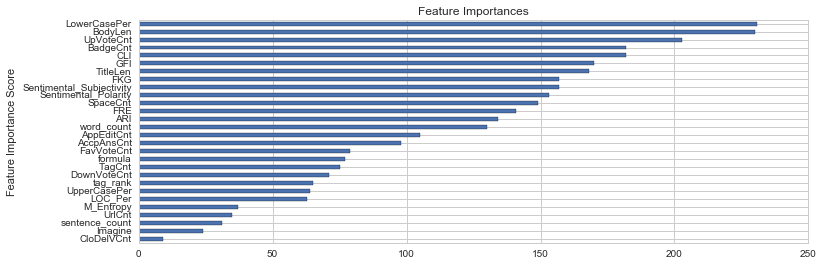

In [164]:
get_performance(xgb5,train,test,Predictors,dtrain_predictions)

In [165]:
xgb5

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=119, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [37]:
train.columns

Index([                 u'BodyLen',             u'LowerCasePer',
                   u'UpperCasePer',                 u'SpaceCnt',
                         u'TagCnt',     u'Sentimental_Polarity',
       u'Sentimental_Subjectivity',                 u'TitleLen',
                         u'UrlCnt',                  u'formula',
                        u'Imagine',               u'word_count',
                 u'sentence_count',                      u'ARI',
                            u'CLI',                      u'FKG',
                            u'FRE',                      u'GFI',
                      u'M_Entropy',                  u'LOC_Per',
                       u'tag_rank',               u'AccpAnsCnt',
                     u'AppEditCnt',                 u'BadgeCnt',
                     u'CloDelVCnt',                u'UpVoteCnt',
                    u'DownVoteCnt',               u'FavVoteCnt',
                          u'Score'],
      dtype='object')